In [1]:
import deconv as dv

import scanpy as sc
import pandas as pd
import torch

%load_ext autoreload
%autoreload 2

/home/lutrarutra/miniforge3/envs/deconv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.__version__, dv.__version__, torch.__version__

('1.11.0', '0.9.3', '2.6.0+cu124')

In [3]:
reference_file = "../data/pbmc/reference.h5ad"
bulk_file = "../data/pbmc/bulk.txt"
cell_types = [
    'CD4 T', 'Monocytes',
    'B cells', 'CD8 T',
    'NK', 'Monocytes',
    'DCs'
]

In [4]:
adata = sc.read_h5ad(reference_file)
adata.X = adata.X.astype("float32").toarray()

dv.tl.scale_log_center(adata)

adata = adata[adata.obs["labels"].astype("str").isin(cell_types), :].copy()

print(adata.obs.groupby("labels").size())
bulk_df = pd.read_table(bulk_file, index_col=0).T
adata.shape

labels
B cells       362
CD4 T        1126
CD8 T         160
DCs            33
Monocytes     648
NK            351
dtype: int64


/tmp/ipykernel_36111/849456279.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby("labels").size())


(2680, 13714)

In [5]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

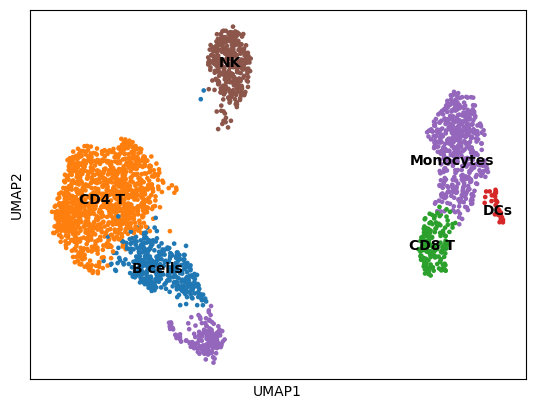

In [6]:
sc.pl.umap(adata, color=["labels"], frameon=True, legend_loc="on data", title="")

## GPU Acceleration

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Define Model and Fit Reference

In [20]:
decon = dv.DeconV(
    adata,
    bulk=bulk_df,
    cell_type_key="labels",  # cell_type_key is the column key in adata.obs that holds the cell type annotations 
    dropout_type="separate",        # separate, shared, or None
    model_type="nb",             # gamma, beta, nb, lognormal, or static    
    device="cuda",
    layer="counts",
    model_bulk_dropout=True
)

Using 13404 common genes between the reference and the bulk data.


In [21]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999)

100%|██████████| 2000/2000 [01:56<00:00, 17.13it/s, loss=2.85e+03, lr=1.35e-02]


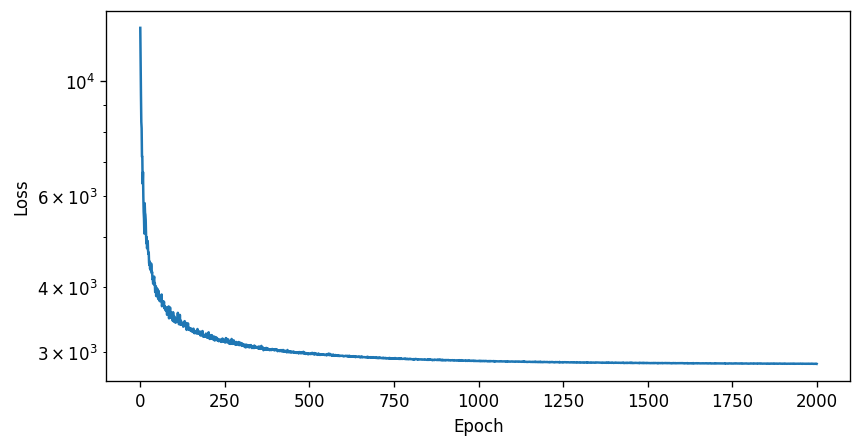

In [22]:
decon.plot_reference_losses()

## (Optional): Asses fit of the model

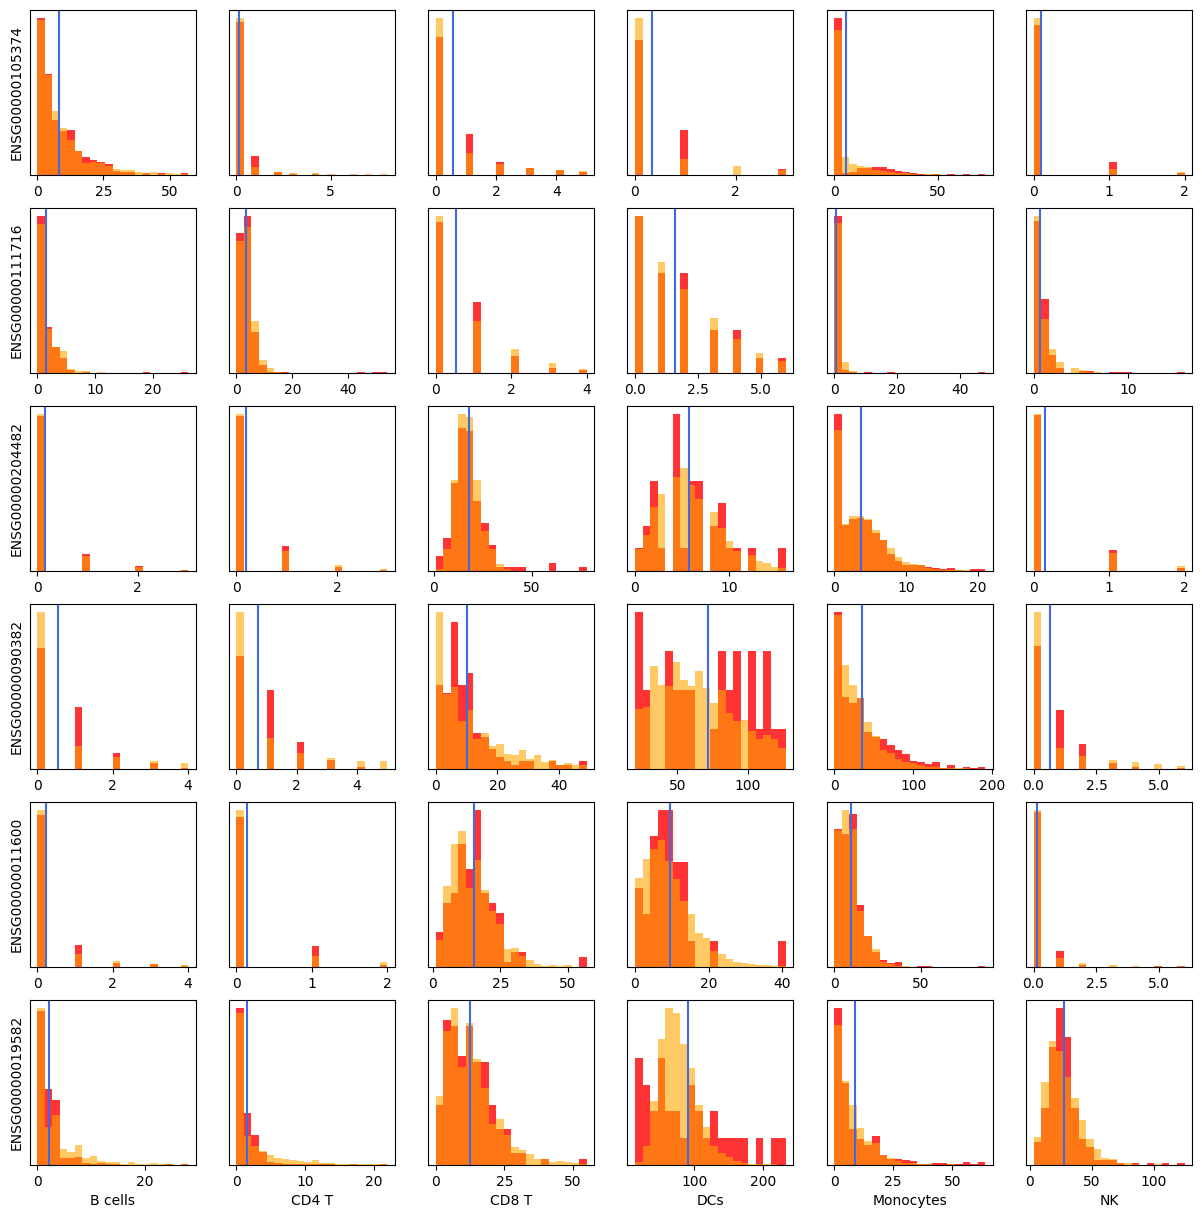

In [23]:
decon.check_fit()

## Deconvolute

In [24]:
proportions = decon.deconvolute(lrd=0.999, lr=0.1, num_epochs=1000)
proportions

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 110.80it/s, loss=5.05e+06, lr=3.68e-02]


,B cells,CD4 T,CD8 T,DCs,Monocytes,NK
453W_PBMC,0.146858,0.192211,0.121727,0.121177,0.395437,0.022590
684C_PBMC,0.110082,0.241227,0.109280,0.130255,0.371646,0.037510
CR3L_PBMC,0.124985,0.206708,0.124257,0.131630,0.378585,0.033835
FLWA_PBMC,0.141948,0.191863,0.148617,0.138332,0.346610,0.032630
FY2H_PBMC,0.120857,0.094701,0.179756,0.132282,0.452321,0.020083
CYFZ_PBMC,0.152777,0.139788,0.146173,0.125990,0.416336,0.018936
925L_PBMC,0.165288,0.189910,0.117326,0.125024,0.367439,0.035013
9JD4_PBMC,0.120902,0.278811,0.106841,0.106725,0.360451,0.026270
G4YW_PBMC,0.116813,0.230595,0.110274,0.128833,0.392463,0.021022
4DUY_PBMC,0.164121,0.168034,0.127817,0.114831,0.394524,0.030674


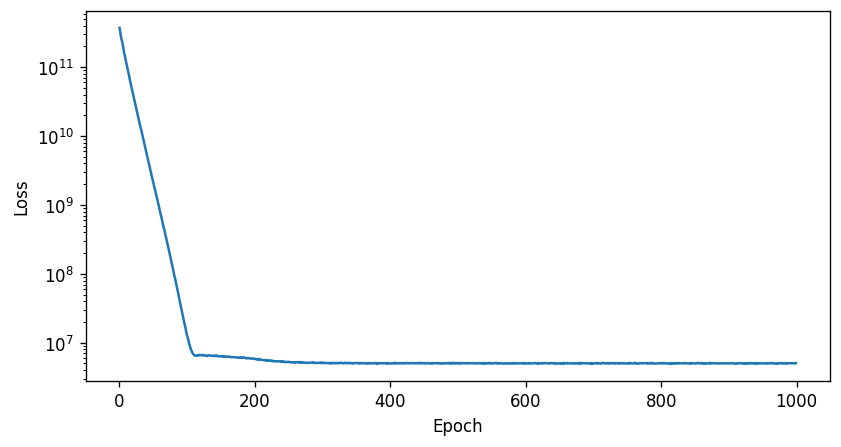

In [25]:
decon.plot_deconvolution_losses()

In [26]:
melt = decon.get_results_df()
melt

,sample,cell_type,est,min,max
0,453W_PBMC,B cells,0.146858,0.015400,0.015980
1,684C_PBMC,B cells,0.110082,0.018130,0.019642
2,CR3L_PBMC,B cells,0.124985,0.019422,0.021091
3,FLWA_PBMC,B cells,0.141948,0.017201,0.018209
4,FY2H_PBMC,B cells,0.120857,0.013819,0.014728
...,...,...,...,...,...
67,9JD4_PBMC,NK,0.026270,0.007234,0.008223
68,G4YW_PBMC,NK,0.021022,0.006319,0.007362
69,4DUY_PBMC,NK,0.030674,0.007429,0.008476
70,CZJE_PBMC,NK,0.034274,0.010247,0.012233


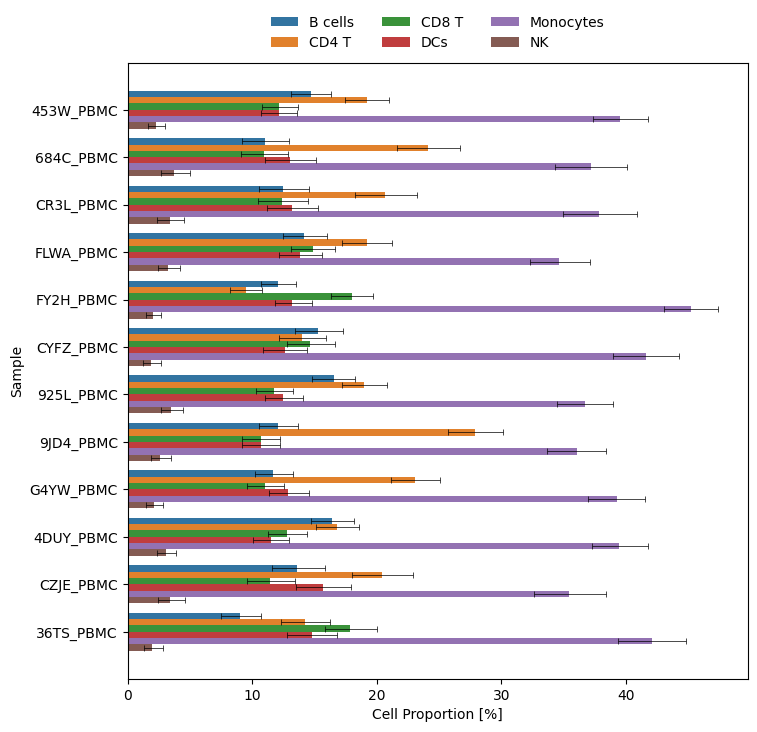

In [27]:
decon.plot_bar_proportions(path="figures/pbmc_bar_proportions.png")

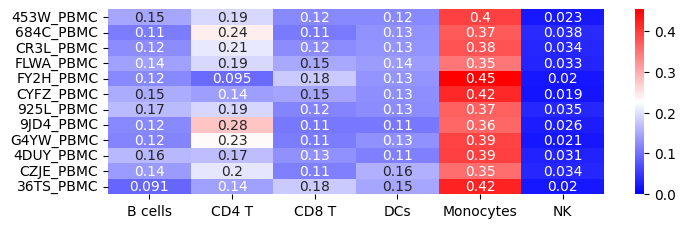

In [28]:
decon.plot_heatmap_proportions(path="figures/pbmc_heatmap_proportions.png")

## Comparison to Ground Truth

In [29]:
true_df = pd.read_csv("../data/pbmc/true.csv", sep=",", index_col=0)

In [30]:
decon.benchmark_rmse_mad_r(true_df=true_df)

(np.float64(0.10492527553665267),
 np.float64(0.09075789700884719),
 np.float64(0.5426730113203754))

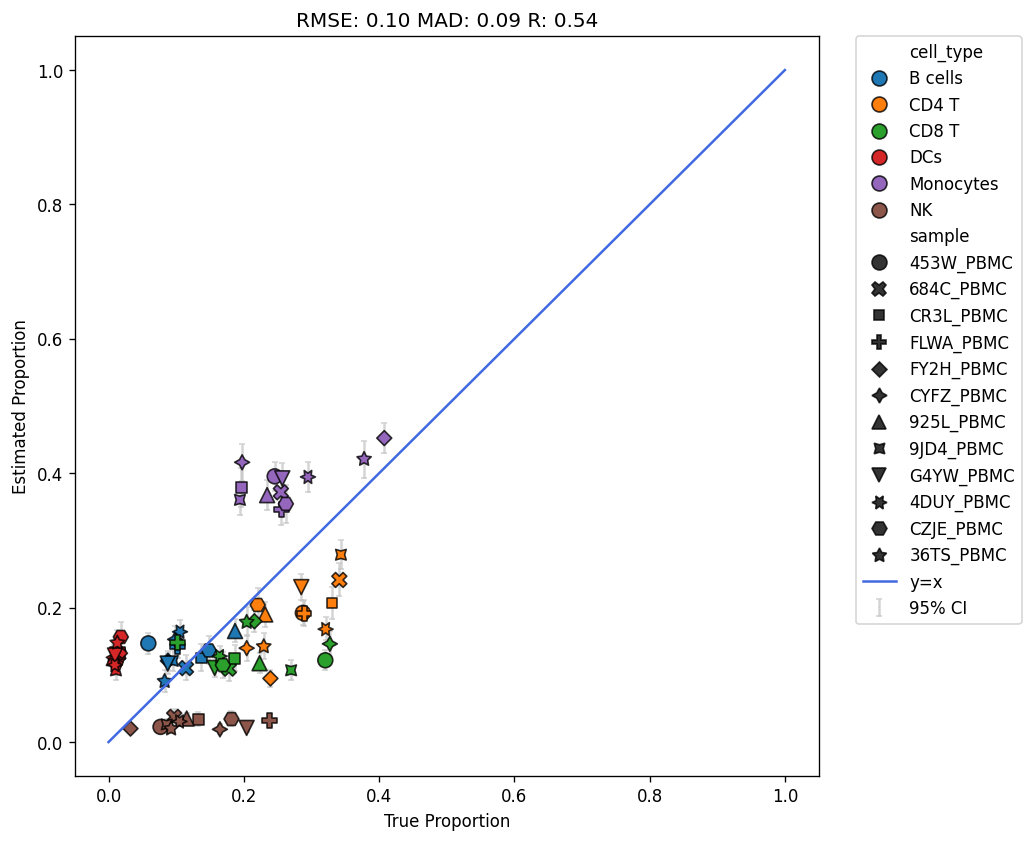

In [31]:
decon.plot_benchmark_scatter(true_df, path="figures/pbmc_benchmark_scatter.png")